# Multi-group Agreement (Communities & Crime)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Communities
and Crime dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Communities & Crime Dataset
A set of features describing a community, and the prediction target is whether the community has an elevated crime rate. Following [43, 41, 42], we predict a binary label for whether the violent crime rate exceeds a threshold of 0.08. Sensitive attributes are race and income level. We use the preprocessing of [43] for this dataset, where the race feature is a binary indicator for whether the feature racePctWhite > 0.85 and the income level is an indicator for whether the income is above the median community income.

COMPAS has $n = 1,994$ instances total, with $d = 113$ features.

In [2]:
attrib = pd.read_csv("./datasets/communities-and-crime/attributes.csv", delim_whitespace=True)
data = pd.read_csv("./datasets/communities-and-crime/communities.data", names=attrib['attributes'])

target_threshold = 0.08
# remove non predicitive features
for c in ['state', 'county', 'community', 'communityname', 'fold']:
    data.drop(columns=c, axis=1, inplace=True)

data = data.replace('?', np.nan).dropna(axis=1)
data["race"] = data['racePctWhite'].apply(
    lambda x: 1 if x >= 0.85 else 0)
income_thresh = data["medIncome"].median()
data["income_level"] = data["medIncome"].apply(
    lambda x: 1 if x > income_thresh else 0)
data = data.drop(columns=['racePctAsian', 'racePctHisp',
                            'racepctblack', 'whitePerCap',
                            'blackPerCap', 'indianPerCap',
                            'AsianPerCap',  # 'OtherPerCap',
                            'HispPerCap',
                            'racePctWhite', 'medIncome'
                            ], axis=1).rename(
    columns={'ViolentCrimesPerPop': "target"})
data["target"] = (data["target"] >= target_threshold).astype(int)
data.head(5)

,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,pctWWage,pctWFarmSelf,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,target,race,income_level
0,0.19,0.33,0.34,0.47,0.29,0.32,0.20,1.0,0.72,0.34,...,0.50,0.51,0.64,0.12,0.26,0.20,0.32,1,1,1
1,0.00,0.16,0.26,0.59,0.35,0.27,0.02,1.0,0.72,0.11,...,0.34,0.60,0.52,0.02,0.12,0.45,0.00,1,0,0
2,0.00,0.42,0.39,0.47,0.28,0.32,0.00,0.0,0.58,0.19,...,0.54,0.67,0.56,0.01,0.21,0.02,0.00,1,0,0
3,0.04,0.77,0.51,0.50,0.34,0.21,0.06,1.0,0.89,0.21,...,0.73,0.64,0.65,0.02,0.39,0.28,0.00,1,0,1
4,0.01,0.55,0.38,0.38,0.23,0.36,0.02,0.9,0.72,0.16,...,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0,1,1


In [3]:
X, y = data.drop("target", axis=1), data["target"]
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variale so we have two classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

print("Communities and Crime Shape: {}".format(data.shape))

% examples (y=1): 72.56770310932798
% examples (y=0): 27.432296890672017
Communities and Crime Shape: (1994, 92)


In [4]:
def communities_gp_indices(df, race_val, income_val):
    if race_val == "NotWhite":
        return np.where((df['race'] == 0) & (df['income_level'] == income_val))
    else:
        return np.where((df['race'] == 1) & (df['income_level'] == income_val))

group_names = ["ALL", "W,H", "W,L", "nW,H", "nW,L", "W", "nW", "H", "L"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
income_gps = [1, 0]

# Traditional disjoint groups
for race in race_gps_coarse:
    for income in income_gps:
        indices = communities_gp_indices(X, race, income)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 1)
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] == 0)
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['income_level'] == 1)
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['income_level'] == 0)
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [5]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (1994, 91)


In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			1595	399
1 (W,H)			500	116
2 (W,L)			308	77
3 (nW,H)			285	71
4 (nW,L)			502	135
5 (W)			808	193
6 (nW)			787	206
7 (H)			785	187
8 (L)			810	212


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.7092731829573935
P(Y=1 | group 1) = 0.39655172413793105
P(Y=1 | group 2) = 0.5714285714285714
P(Y=1 | group 3) = 0.8732394366197183
P(Y=1 | group 4) = 0.9703703703703703
P(Y=1 | group 5) = 0.46632124352331605
P(Y=1 | group 6) = 0.9368932038834952
P(Y=1 | group 7) = 0.5775401069518716
P(Y=1 | group 8) = 0.8254716981132075


## Utilities for Training/Evaluation

In [8]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [9]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [11]:
# Train LogisticRegression models, one per group
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

lr_erm_test_err = {}
for g in range(num_groups):
    lr_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.17042606516290726 (+/-0.026620984192520472; n=399)
group 1 (W,H): 0.28448275862068967 (+/-0.0592412249675808; n=116)
group 2 (W,L): 0.3116883116883117 (+/-0.0746487372646051; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.2694300518134715 (+/-0.04516377784182492; n=193)
group 6 (nW): 0.04854368932038835 (+/-0.021175915873535393; n=206)
group 7 (H): 0.21390374331550802 (+/-0.04240736137175557; n=187)
group 8 (L): 0.1320754716981132 (+/-0.03288509748420407; n=212)
PREPEND group 0 (ALL): 0.17543859649122806 (+/-0.026927908522675775; n=399)
PREPEND group 1 (W,H): 0.28448275862068967 (+/-0.0592412249675808; n=116)
PREPEND group 2 (W,L): 0.3116883116883117 (+/-0.0746487372646051; n=77)
PREPEND group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
PREPEND group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
PREPEND group 5 (W): 0.29533678756

In [12]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,H, W) agreement on G1 (W,H):	0.896551724137931
(W, H) agreement on G1 (W,H):	0.8793103448275862
(W,H, H) agreement on G1 (W,H):	0.9655172413793104
(W,L, W) agreement on G2 (W,L):	0.8051948051948052
(W, L) agreement on G2 (W,L):	0.7532467532467533
(W,L, L) agreement on G2 (W,L):	0.8961038961038961
(nW,H, nW) agreement on G3 (nW,H):	0.9577464788732394
(nW, H) agreement on G3 (nW,H):	0.9295774647887324
(nW,H, H) agreement on G3 (nW,H):	0.9436619718309859
(nW,L, nW) agreement on G4 (nW,L):	1.0
(nW, L) agreement on G4 (nW,L):	1.0
(nW,L, L) agreement on G4 (nW,L):	1.0

(ALL, W,H) agreement:	0.899749373433584
(ALL, W,L) agreement:	0.8120300751879699
(ALL, nW,H) agreement:	0.8145363408521303
(ALL, nW,L) agreement:	0.7293233082706767
(ALL, W) agreement:	0.9624060150375939
(ALL, nW) agreement:	0.7769423558897243
(ALL, H) agreement:	0.9047619047619048
(ALL, L) agreement:	0.7994987468671679


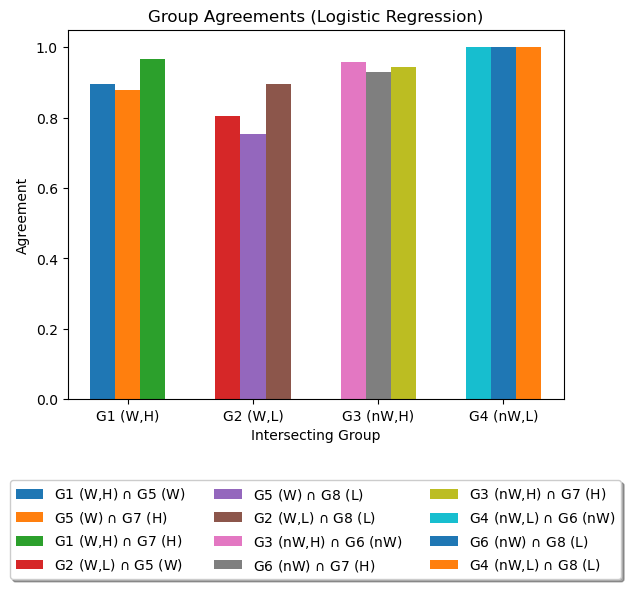

In [13]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_test_err = {}
for g in range(num_groups):
    dt_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, dt_test_err[g], std_err(dt_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

dt_erm_test_err = {}
for g in range(num_groups):
    dt_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.17543859649122806 (+/-0.026927908522675775; n=399)
group 1 (W,H): 0.3793103448275862 (+/-0.06371190641911445; n=116)
group 2 (W,L): 0.4155844155844156 (+/-0.07942553632794164; n=77)
group 3 (nW,H): 0.14084507042253522 (+/-0.0583838045651255; n=71)
group 4 (nW,L): 0.044444444444444446 (+/-0.025083308837926508; n=135)
group 5 (W): 0.32124352331606215 (+/-0.04753467477695333; n=193)
group 6 (nW): 0.06796116504854369 (+/-0.02479869341488223; n=206)
group 7 (H): 0.20855614973262032 (+/-0.04201610108249694; n=187)
group 8 (L): 0.16981132075471697 (+/-0.036468574750367834; n=212)
group 0 (ALL): 0.17543859649122806 (+/-0.026927908522675775; n=399)
group 1 (W,H): 0.3793103448275862 (+/-0.06371190641911445; n=116)
group 2 (W,L): 0.4155844155844156 (+/-0.07942553632794164; n=77)
group 3 (nW,H): 0.14084507042253522 (+/-0.0583838045651255; n=71)
group 4 (nW,L): 0.044444444444444446 (+/-0.025083308837926508; n=135)
group 5 (W): 0.32124352331606215 (+/-0.04753467477695333; n=193)
gro

In [16]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,H, W) agreement on G1 (W,H):	0.6637931034482759
(W, H) agreement on G1 (W,H):	0.6982758620689655
(W,H, H) agreement on G1 (W,H):	0.7068965517241379
(W,L, W) agreement on G2 (W,L):	0.6493506493506493
(W, L) agreement on G2 (W,L):	0.7532467532467533
(W,L, L) agreement on G2 (W,L):	0.7662337662337663
(nW,H, nW) agreement on G3 (nW,H):	0.971830985915493
(nW, H) agreement on G3 (nW,H):	0.9859154929577465
(nW,H, H) agreement on G3 (nW,H):	0.9577464788732394
(nW,L, nW) agreement on G4 (nW,L):	0.9851851851851852
(nW, L) agreement on G4 (nW,L):	0.9555555555555556
(nW,L, L) agreement on G4 (nW,L):	0.9407407407407408

(ALL, W,H) agreement:	0.8421052631578947
(ALL, W,L) agreement:	0.7293233082706767
(ALL, nW,H) agreement:	0.7994987468671679
(ALL, nW,L) agreement:	0.7894736842105263
(ALL, W) agreement:	0.7619047619047619
(ALL, nW) agreement:	0.9047619047619048
(ALL, H) agreement:	0.8596491228070176
(ALL, L) agreement:	0.8596491228070176


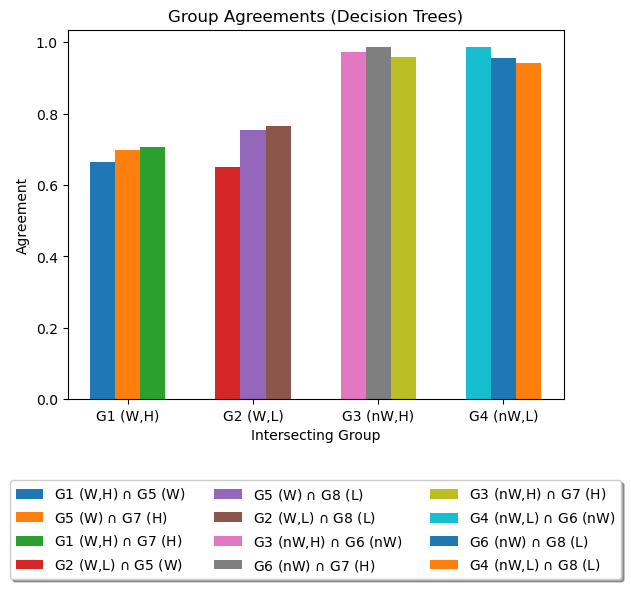

In [17]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Random Forests

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

rf_erm_test_err = {}
for g in range(num_groups):
    rf_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.17293233082706766 (+/-0.026775474112399687; n=399)
group 1 (W,H): 0.25 (+/-0.05685735326841775; n=116)
group 2 (W,L): 0.3246753246753247 (+/-0.07546587053869824; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.26424870466321243 (+/-0.04488573018878704; n=193)
group 6 (nW): 0.07281553398058252 (+/-0.02560215251715567; n=206)
group 7 (H): 0.21390374331550802 (+/-0.04240736137175557; n=187)
group 8 (L): 0.1320754716981132 (+/-0.03288509748420407; n=212)
group 0 (ALL): 0.17293233082706766 (+/-0.026775474112399687; n=399)
group 1 (W,H): 0.25 (+/-0.05685735326841775; n=116)
group 2 (W,L): 0.3246753246753247 (+/-0.07546587053869824; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.26424870466321243 (+/-0.04488573018878704; n=193)
group 6 (nW): 0.07281553398058252 (

In [20]:
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,H, W) agreement on G1 (W,H):	0.9137931034482759
(W, H) agreement on G1 (W,H):	0.9396551724137931
(W,H, H) agreement on G1 (W,H):	0.9224137931034483
(W,L, W) agreement on G2 (W,L):	0.8831168831168831
(W, L) agreement on G2 (W,L):	0.948051948051948
(W,L, L) agreement on G2 (W,L):	0.935064935064935
(nW,H, nW) agreement on G3 (nW,H):	0.971830985915493
(nW, H) agreement on G3 (nW,H):	0.9295774647887324
(nW,H, H) agreement on G3 (nW,H):	0.9577464788732394
(nW,L, nW) agreement on G4 (nW,L):	1.0
(nW, L) agreement on G4 (nW,L):	1.0
(nW,L, L) agreement on G4 (nW,L):	1.0

(ALL, W,H) agreement:	0.9323308270676691
(ALL, W,L) agreement:	0.8095238095238095
(ALL, nW,H) agreement:	0.8771929824561403
(ALL, nW,L) agreement:	0.7719298245614035
(ALL, W) agreement:	0.9699248120300752
(ALL, nW) agreement:	0.8671679197994987
(ALL, H) agreement:	0.9598997493734336
(ALL, L) agreement:	0.8220551378446115


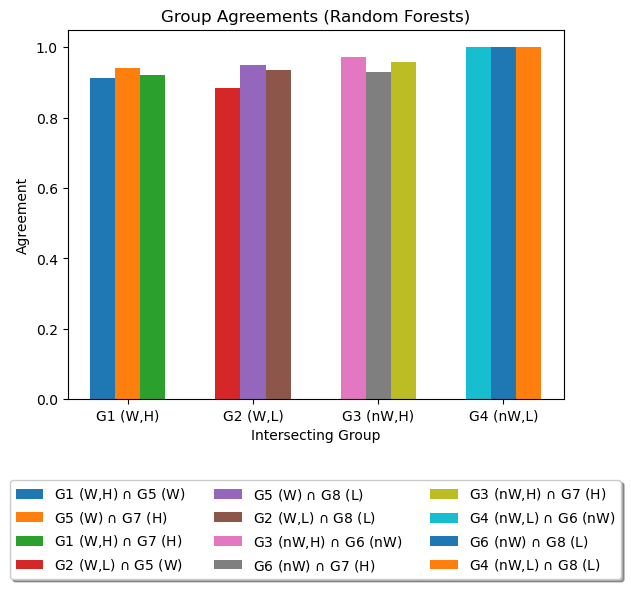

In [21]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, rf_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, rf_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, rf_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, rf_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, rf_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, rf_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, rf_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, rf_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, rf_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, rf_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, rf_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, rf_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Random Forests)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Gradient-Boosted Trees

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err = {}
for g in range(num_groups):
    gb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, gb_test_err[g], std_err(gb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

gb_erm_test_err = {}
for g in range(num_groups):
    gb_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.17042606516290726 (+/-0.026620984192520472; n=399)
group 1 (W,H): 0.2672413793103448 (+/-0.058105644644586105; n=116)
group 2 (W,L): 0.3246753246753247 (+/-0.07546587053869824; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.05185185185185185 (+/-0.026987853869194004; n=135)
group 5 (W): 0.30569948186528495 (+/-0.0468983365981611; n=193)
group 6 (nW): 0.06310679611650485 (+/-0.02395876887131869; n=206)
group 7 (H): 0.22994652406417113 (+/-0.04351791322544174; n=187)
group 8 (L): 0.12264150943396226 (+/-0.03186062951647461; n=212)
group 0 (ALL): 0.17042606516290726 (+/-0.026620984192520472; n=399)
group 1 (W,H): 0.2672413793103448 (+/-0.058105644644586105; n=116)
group 2 (W,L): 0.3246753246753247 (+/-0.07546587053869824; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.05185185185185185 (+/-0.026987853869194004; n=135)
group 5 (W): 0.30569948186528495 (+/-0.0468983365981611; n=193)
grou

In [24]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,H, W) agreement on G1 (W,H):	0.8448275862068966
(W, H) agreement on G1 (W,H):	0.8706896551724138
(W,H, H) agreement on G1 (W,H):	0.853448275862069
(W,L, W) agreement on G2 (W,L):	0.8831168831168831
(W, L) agreement on G2 (W,L):	0.922077922077922
(W,L, L) agreement on G2 (W,L):	0.9090909090909091
(nW,H, nW) agreement on G3 (nW,H):	1.0
(nW, H) agreement on G3 (nW,H):	0.9154929577464789
(nW,H, H) agreement on G3 (nW,H):	0.9154929577464789
(nW,L, nW) agreement on G4 (nW,L):	0.9777777777777777
(nW, L) agreement on G4 (nW,L):	1.0
(nW,L, L) agreement on G4 (nW,L):	0.9777777777777777

(ALL, W,H) agreement:	0.8596491228070176
(ALL, W,L) agreement:	0.7769423558897243
(ALL, nW,H) agreement:	0.8220551378446115
(ALL, nW,L) agreement:	0.8270676691729323
(ALL, W) agreement:	0.9448621553884712
(ALL, nW) agreement:	0.8796992481203008
(ALL, H) agreement:	0.8395989974937343
(ALL, L) agreement:	0.7744360902255639


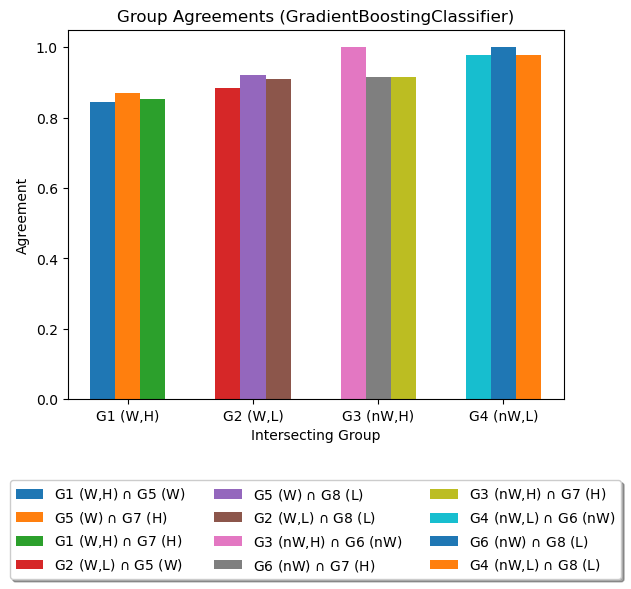

In [25]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (GradientBoostingClassifier)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# XGBoost

In [26]:
from xgboost import XGBClassifier

In [27]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err = {}
for g in range(num_groups):
    xgb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, xgb_test_err[g], std_err(xgb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

xgb_erm_test_err = {}
for g in range(num_groups):
    xgb_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.18045112781954886 (+/-0.027226748447410222; n=399)
group 1 (W,H): 0.23275862068965517 (+/-0.05548874461582034; n=116)
group 2 (W,L): 0.3116883116883117 (+/-0.0746487372646051; n=77)
group 3 (nW,H): 0.14084507042253522 (+/-0.0583838045651255; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.29533678756476683 (+/-0.04643932689703463; n=193)
group 6 (nW): 0.06310679611650485 (+/-0.02395876887131869; n=206)
group 7 (H): 0.20855614973262032 (+/-0.04201610108249694; n=187)
group 8 (L): 0.13679245283018868 (+/-0.03337611247229231; n=212)
group 0 (ALL): 0.18045112781954886 (+/-0.027226748447410222; n=399)
group 1 (W,H): 0.23275862068965517 (+/-0.05548874461582034; n=116)
group 2 (W,L): 0.3116883116883117 (+/-0.0746487372646051; n=77)
group 3 (nW,H): 0.14084507042253522 (+/-0.0583838045651255; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.29533678756476683 (+/-0.04643932689703463; n=193)
group 6 

In [28]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,H, W) agreement on G1 (W,H):	0.9051724137931034
(W, H) agreement on G1 (W,H):	0.8189655172413793
(W,H, H) agreement on G1 (W,H):	0.8793103448275862
(W,L, W) agreement on G2 (W,L):	0.8831168831168831
(W, L) agreement on G2 (W,L):	0.8701298701298701
(W,L, L) agreement on G2 (W,L):	0.961038961038961
(nW,H, nW) agreement on G3 (nW,H):	0.9577464788732394
(nW, H) agreement on G3 (nW,H):	0.9577464788732394
(nW,H, H) agreement on G3 (nW,H):	0.9154929577464789
(nW,L, nW) agreement on G4 (nW,L):	1.0
(nW, L) agreement on G4 (nW,L):	1.0
(nW,L, L) agreement on G4 (nW,L):	1.0

(ALL, W,H) agreement:	0.9022556390977443
(ALL, W,L) agreement:	0.849624060150376
(ALL, nW,H) agreement:	0.8020050125313283
(ALL, nW,L) agreement:	0.7568922305764411
(ALL, W) agreement:	0.949874686716792
(ALL, nW) agreement:	0.8671679197994987
(ALL, H) agreement:	0.9273182957393483
(ALL, L) agreement:	0.8120300751879699


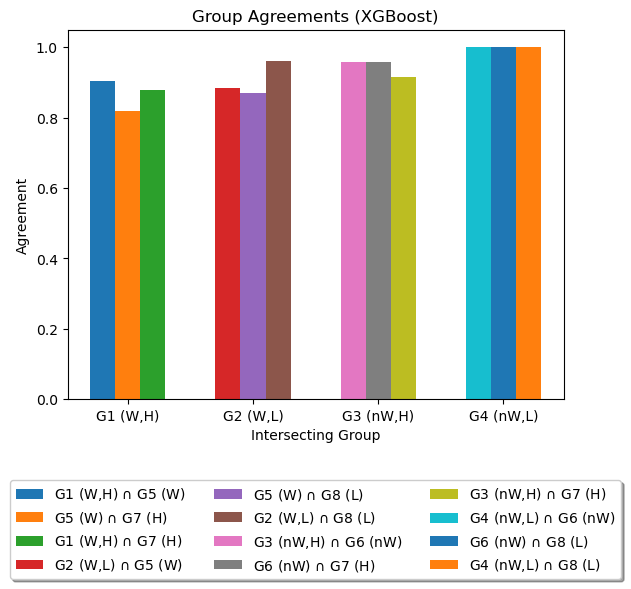

In [29]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        rf_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

rf_erm_test_err = {}
for g in range(num_groups):
    rf_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.17293233082706766 (+/-0.026775474112399687; n=399)
group 1 (W,H): 0.25 (+/-0.05685735326841775; n=116)
group 2 (W,L): 0.3246753246753247 (+/-0.07546587053869824; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.26424870466321243 (+/-0.04488573018878704; n=193)
group 6 (nW): 0.07281553398058252 (+/-0.02560215251715567; n=206)
group 7 (H): 0.21390374331550802 (+/-0.04240736137175557; n=187)
group 8 (L): 0.1320754716981132 (+/-0.03288509748420407; n=212)
group 0 (ALL): 0.17293233082706766 (+/-0.026775474112399687; n=399)
group 1 (W,H): 0.25 (+/-0.05685735326841775; n=116)
group 2 (W,L): 0.3246753246753247 (+/-0.07546587053869824; n=77)
group 3 (nW,H): 0.1267605633802817 (+/-0.055839892588327236; n=71)
group 4 (nW,L): 0.02962962962962963 (+/-0.02063858833732672; n=135)
group 5 (W): 0.26424870466321243 (+/-0.04488573018878704; n=193)
group 6 (nW): 0.07281553398058252 (

In [32]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,H, W) agreement on G1 (W,H):	0.9137931034482759
(W, H) agreement on G1 (W,H):	0.9396551724137931
(W,H, H) agreement on G1 (W,H):	0.9224137931034483
(W,L, W) agreement on G2 (W,L):	0.8831168831168831
(W, L) agreement on G2 (W,L):	0.948051948051948
(W,L, L) agreement on G2 (W,L):	0.935064935064935
(nW,H, nW) agreement on G3 (nW,H):	0.971830985915493
(nW, H) agreement on G3 (nW,H):	0.9295774647887324
(nW,H, H) agreement on G3 (nW,H):	0.9577464788732394
(nW,L, nW) agreement on G4 (nW,L):	1.0
(nW, L) agreement on G4 (nW,L):	1.0
(nW,L, L) agreement on G4 (nW,L):	1.0

(ALL, W,H) agreement:	0.9323308270676691
(ALL, W,L) agreement:	0.8095238095238095
(ALL, nW,H) agreement:	0.8771929824561403
(ALL, nW,L) agreement:	0.7719298245614035
(ALL, W) agreement:	0.9699248120300752
(ALL, nW) agreement:	0.8671679197994987
(ALL, H) agreement:	0.9598997493734336
(ALL, L) agreement:	0.8220551378446115


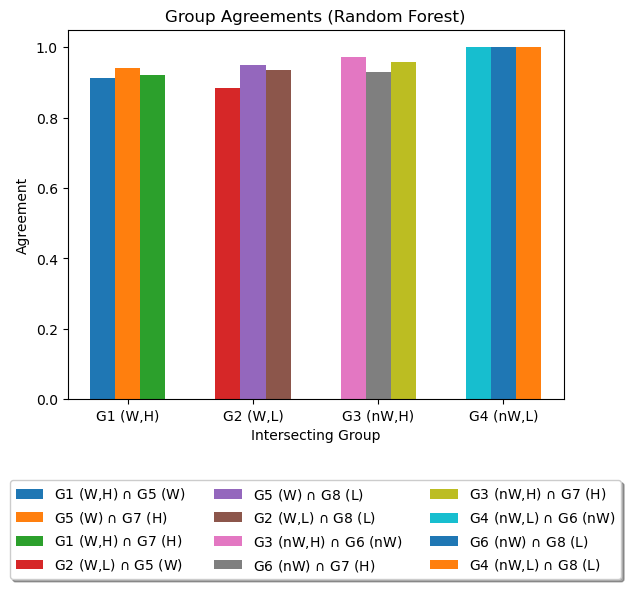

In [33]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, rf_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, rf_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, rf_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, rf_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, rf_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, rf_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, rf_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, rf_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, rf_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, rf_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, rf_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, rf_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Random Forest)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err = {}
for g in range(num_groups):
    ada_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, ada_test_err[g], std_err(ada_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

ada_erm_test_err = {}
for g in range(num_groups):
    ada_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.18045112781954886 (+/-0.027226748447410222; n=399)
group 1 (W,H): 0.3103448275862069 (+/-0.06074691926014174; n=116)
group 2 (W,L): 0.35064935064935066 (+/-0.07690344486542755; n=77)
group 3 (nW,H): 0.11267605633802817 (+/-0.053069224700514867; n=71)
group 4 (nW,L): 0.037037037037037035 (+/-0.02298640336422871; n=135)
group 5 (W): 0.30569948186528495 (+/-0.0468983365981611; n=193)
group 6 (nW): 0.06310679611650485 (+/-0.02395876887131869; n=206)
group 7 (H): 0.20320855614973263 (+/-0.04161381389028053; n=187)
group 8 (L): 0.14150943396226415 (+/-0.03385380807736542; n=212)
group 0 (ALL): 0.18045112781954886 (+/-0.027226748447410222; n=399)
group 1 (W,H): 0.3103448275862069 (+/-0.06074691926014174; n=116)
group 2 (W,L): 0.35064935064935066 (+/-0.07690344486542755; n=77)
group 3 (nW,H): 0.11267605633802817 (+/-0.053069224700514867; n=71)
group 4 (nW,L): 0.037037037037037035 (+/-0.02298640336422871; n=135)
group 5 (W): 0.30569948186528495 (+/-0.0468983365981611; n=193)
gr

In [36]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,H, W) agreement on G1 (W,H):	0.8620689655172413
(W, H) agreement on G1 (W,H):	0.8448275862068966
(W,H, H) agreement on G1 (W,H):	0.8275862068965517
(W,L, W) agreement on G2 (W,L):	0.8181818181818182
(W, L) agreement on G2 (W,L):	0.8051948051948052
(W,L, L) agreement on G2 (W,L):	0.8831168831168831
(nW,H, nW) agreement on G3 (nW,H):	0.9577464788732394
(nW, H) agreement on G3 (nW,H):	0.9577464788732394
(nW,H, H) agreement on G3 (nW,H):	0.9154929577464789
(nW,L, nW) agreement on G4 (nW,L):	0.9925925925925926
(nW, L) agreement on G4 (nW,L):	1.0
(nW,L, L) agreement on G4 (nW,L):	0.9925925925925926

(ALL, W,H) agreement:	0.8471177944862155
(ALL, W,L) agreement:	0.8220551378446115
(ALL, nW,H) agreement:	0.8095238095238095
(ALL, nW,L) agreement:	0.7794486215538847
(ALL, W) agreement:	0.8872180451127819
(ALL, nW) agreement:	0.849624060150376
(ALL, H) agreement:	0.9122807017543859
(ALL, L) agreement:	0.7894736842105263


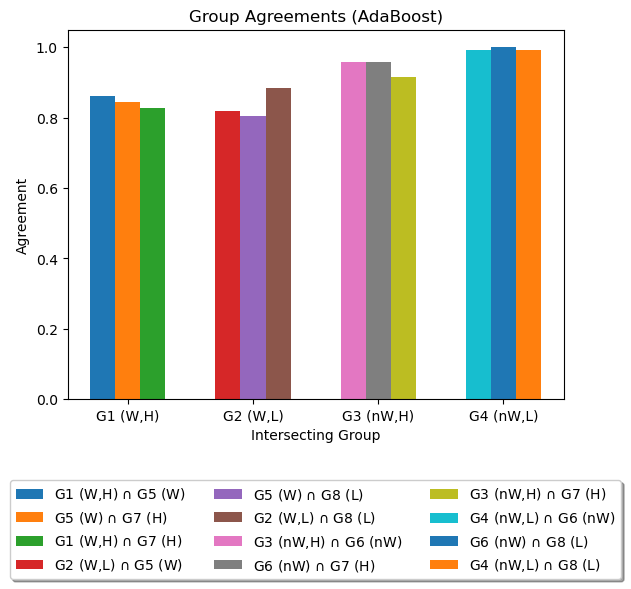

In [37]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, ada_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, ada_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, ada_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, ada_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, ada_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, ada_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, ada_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, ada_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, ada_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, ada_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, ada_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, ada_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# All Together

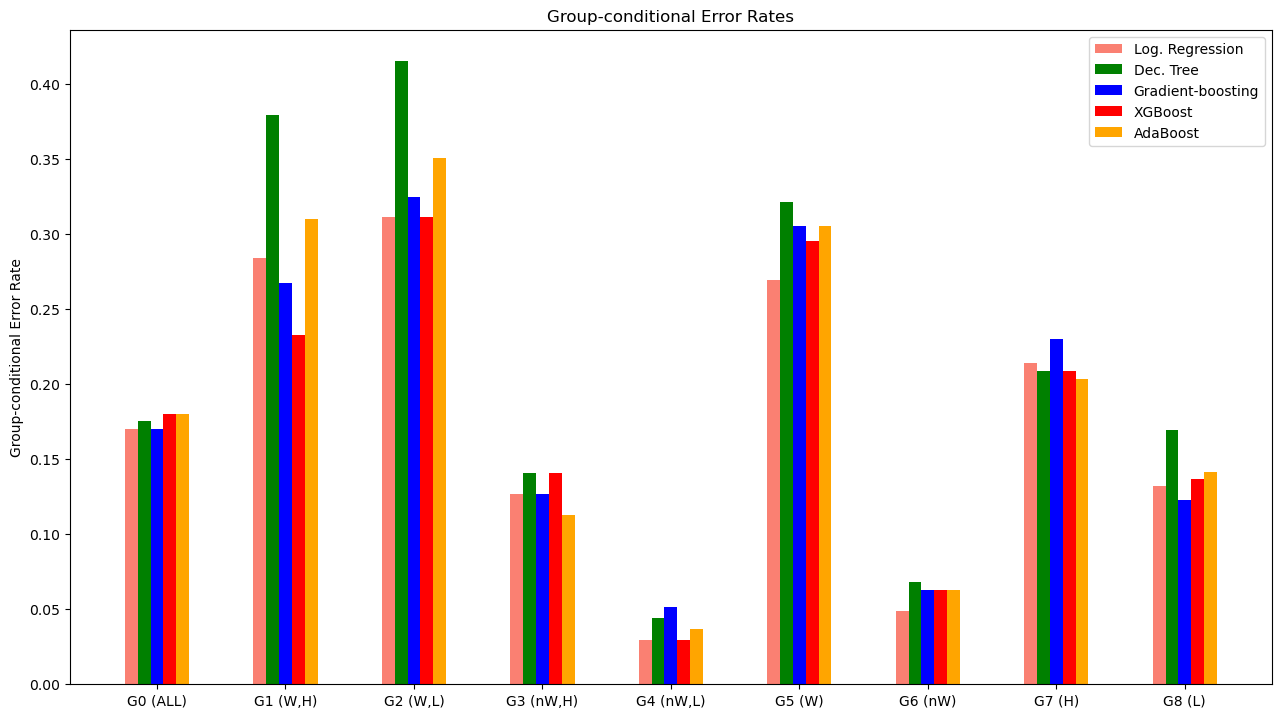

In [38]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, label="Log. Regression", color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, label="Dec. Tree", color="green")
        ax.bar(g, gb_test_err[g], bar_width, label="Gradient-boosting", color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, label="XGBoost", color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, color="green")
        ax.bar(g, gb_test_err[g], bar_width, color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

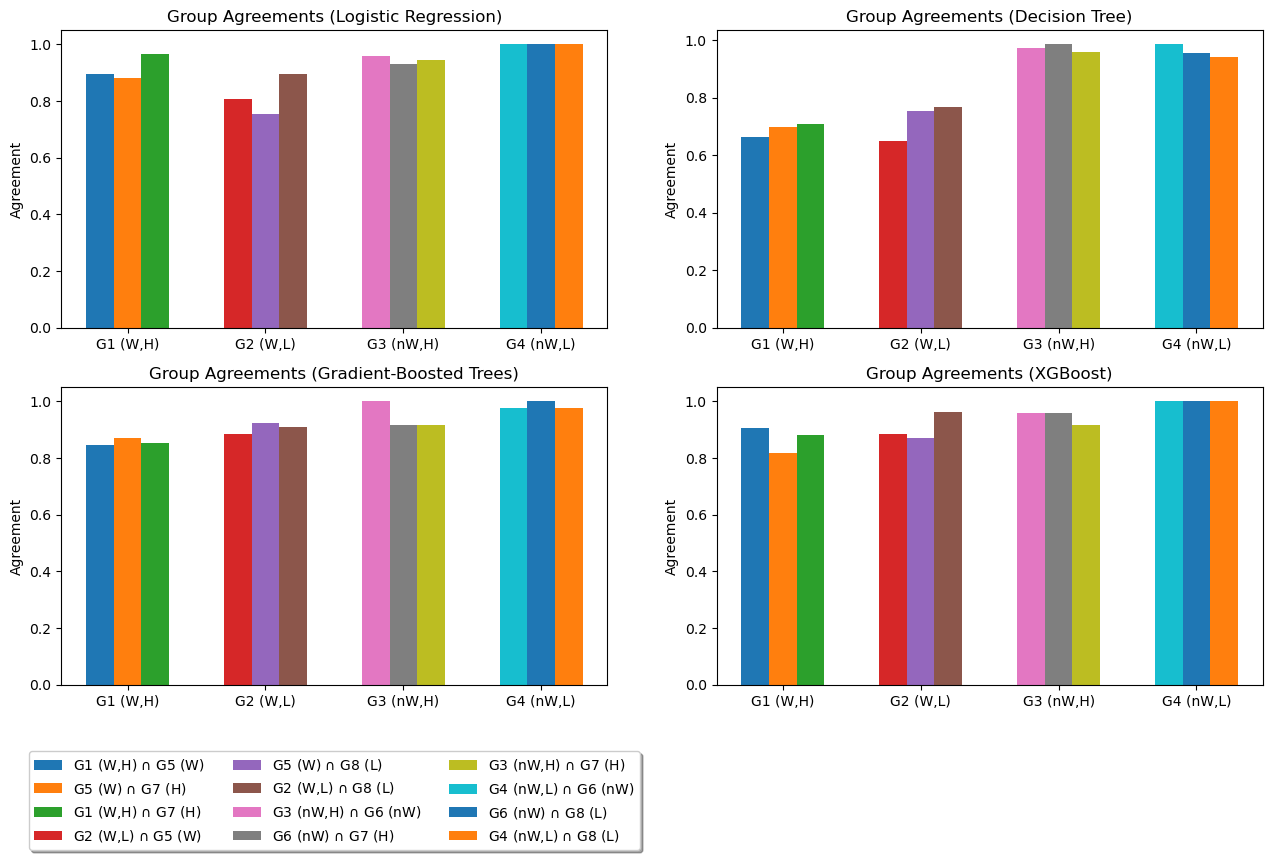

In [39]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
rect11 = ax[0][0].bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][0].bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][0].bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][0].bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][0].bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][0].bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][0].bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][0].bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][0].bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][0].bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][0].bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][0].bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))

# DECISION TREE
rect11 = ax[0][1].bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][1].bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][1].bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][1].bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][1].bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][1].bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][1].bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][1].bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][1].bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][1].bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][1].bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][1].bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][1].set_ylabel('Agreement')
ax[0][1].set_title('Group Agreements (Decision Tree)')
ax[0][1].set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))


# GRADIENT-BOOSTED TREES
rect11 = ax[1][0].bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][0].bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][0].bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][0].bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][0].bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][0].bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][0].bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][0].bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][0].bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][0].bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][0].bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][0].bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))

# XGBOOST
rect11 = ax[1][1].bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][1].bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][1].bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][1].bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][1].bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][1].bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][1].bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][1].bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][1].bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][1].bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][1].bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][1].bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

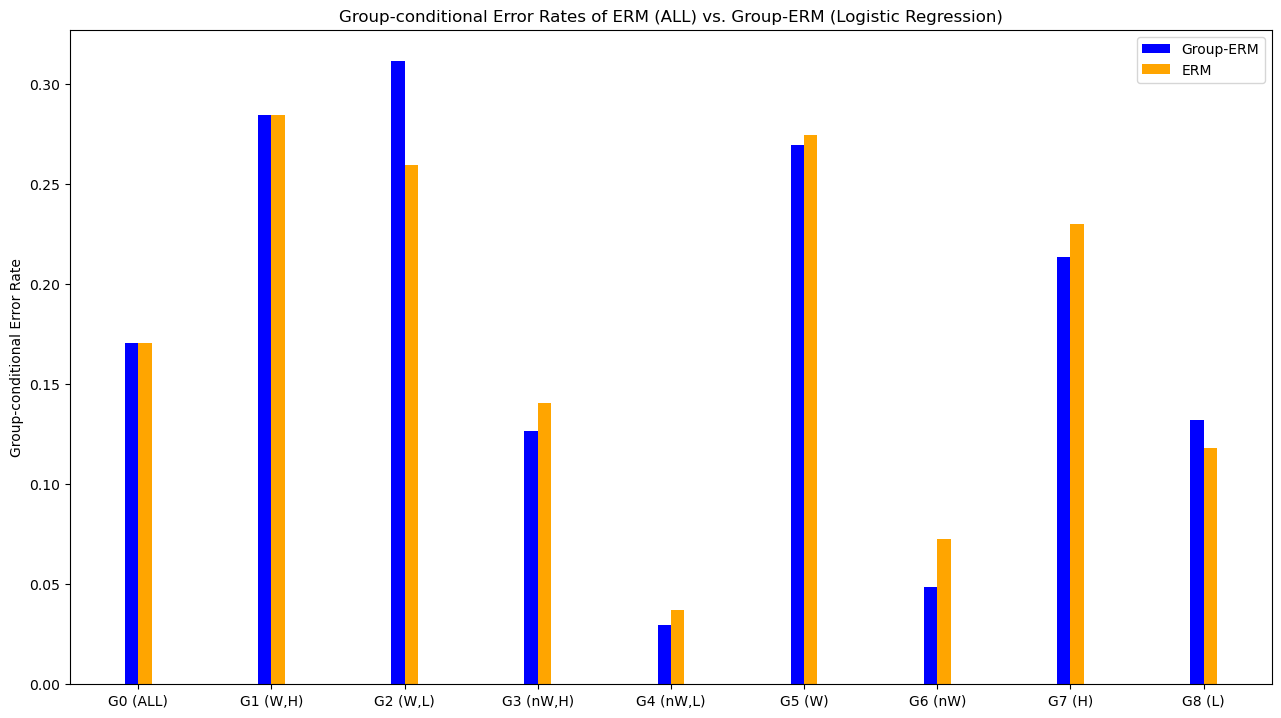

In [40]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, lr_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, lr_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, lr_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, lr_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Logistic Regression)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

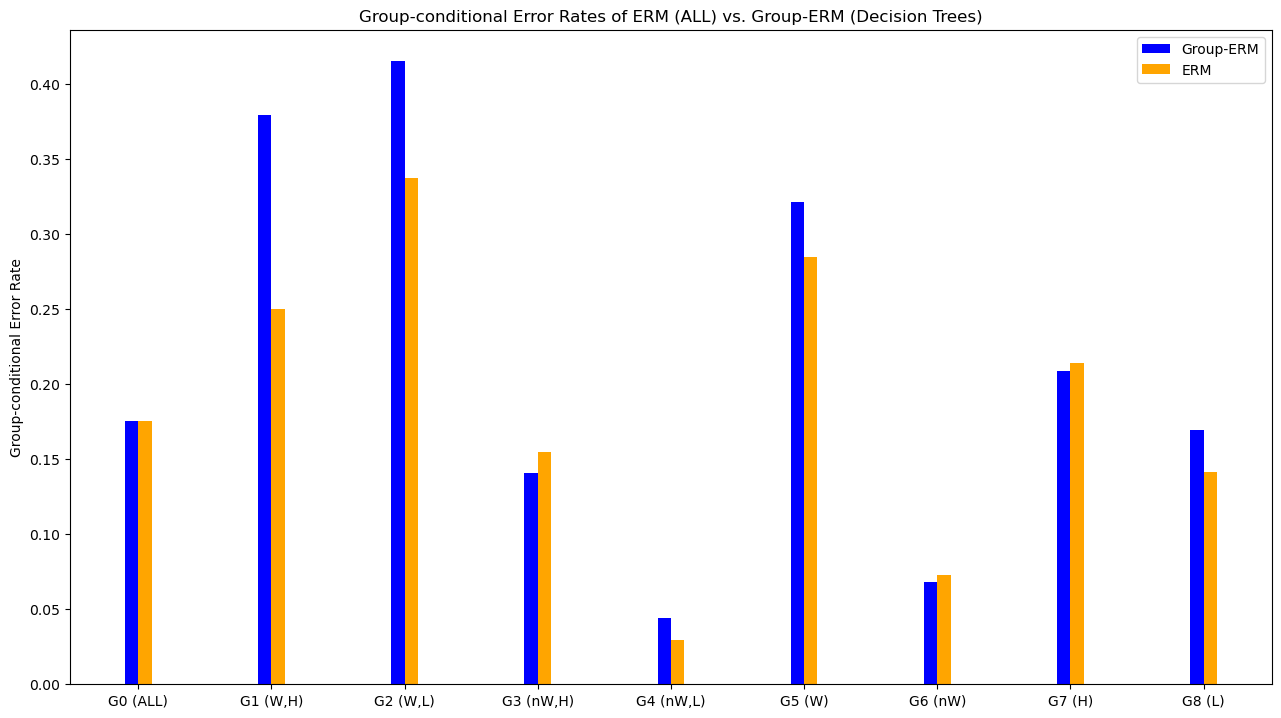

In [41]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, dt_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, dt_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, dt_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, dt_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Decision Trees)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

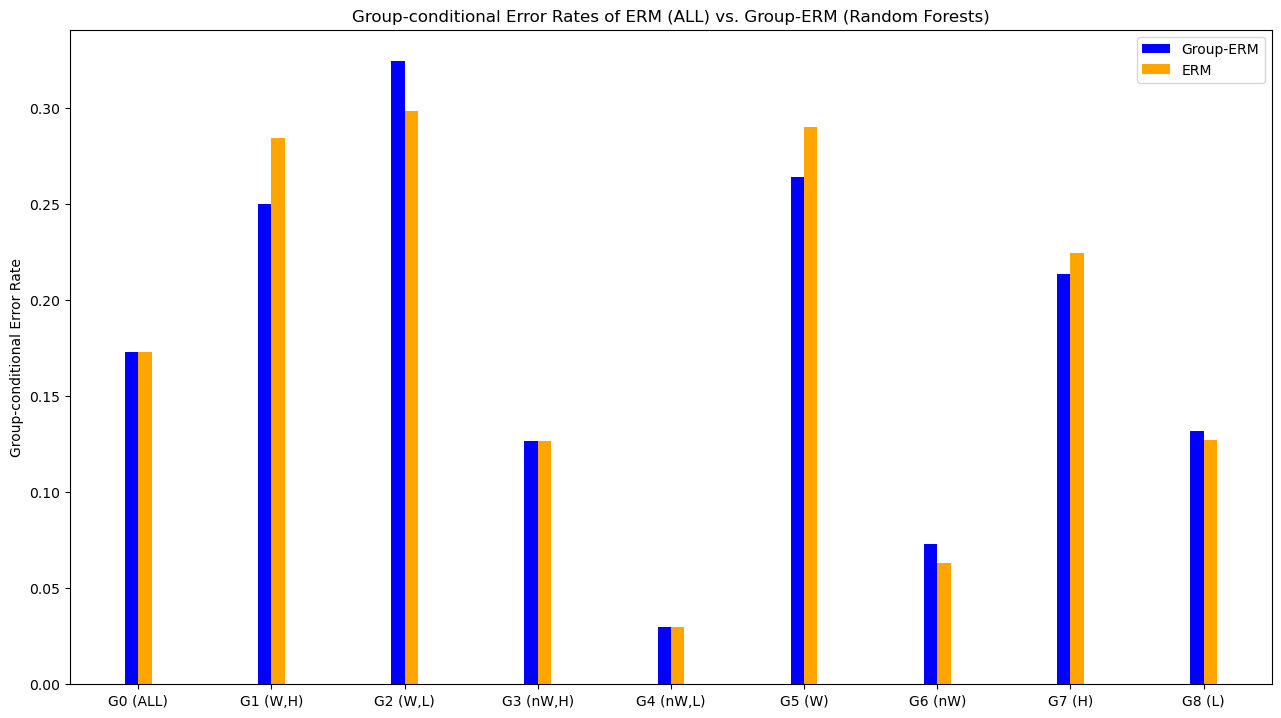

In [42]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, rf_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, rf_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Random Forests)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

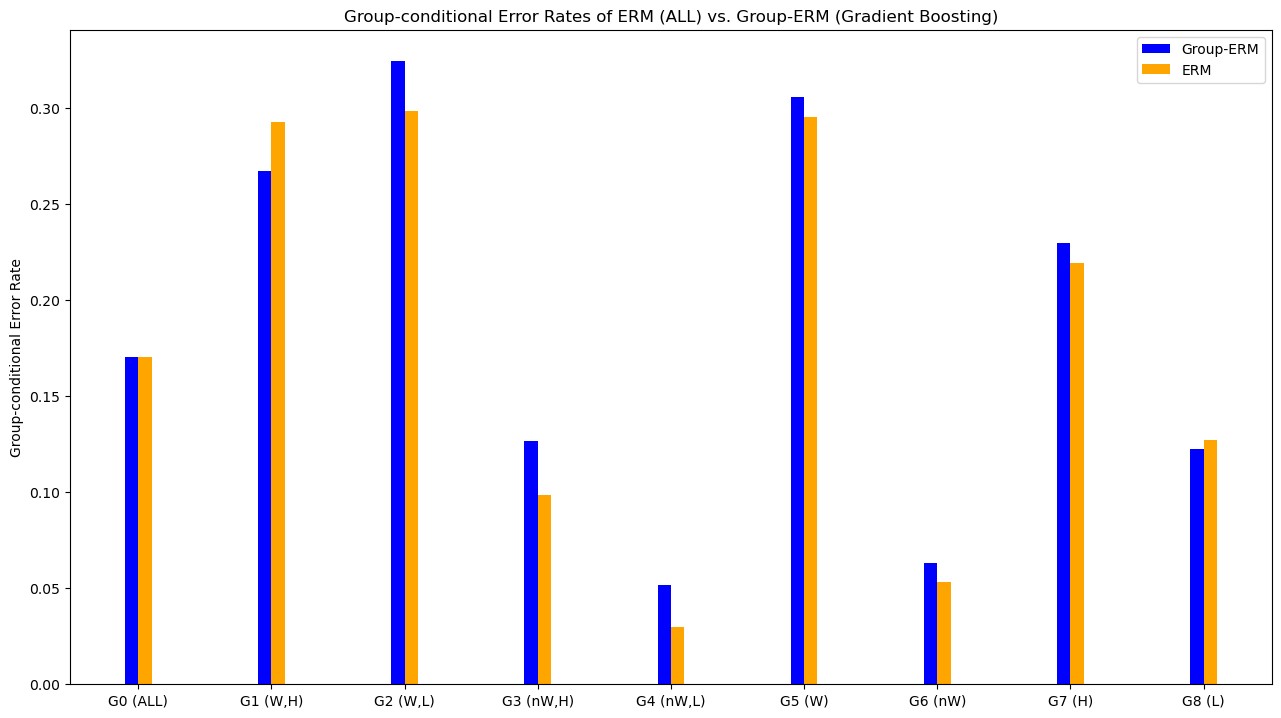

In [43]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, gb_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, gb_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Gradient Boosting)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

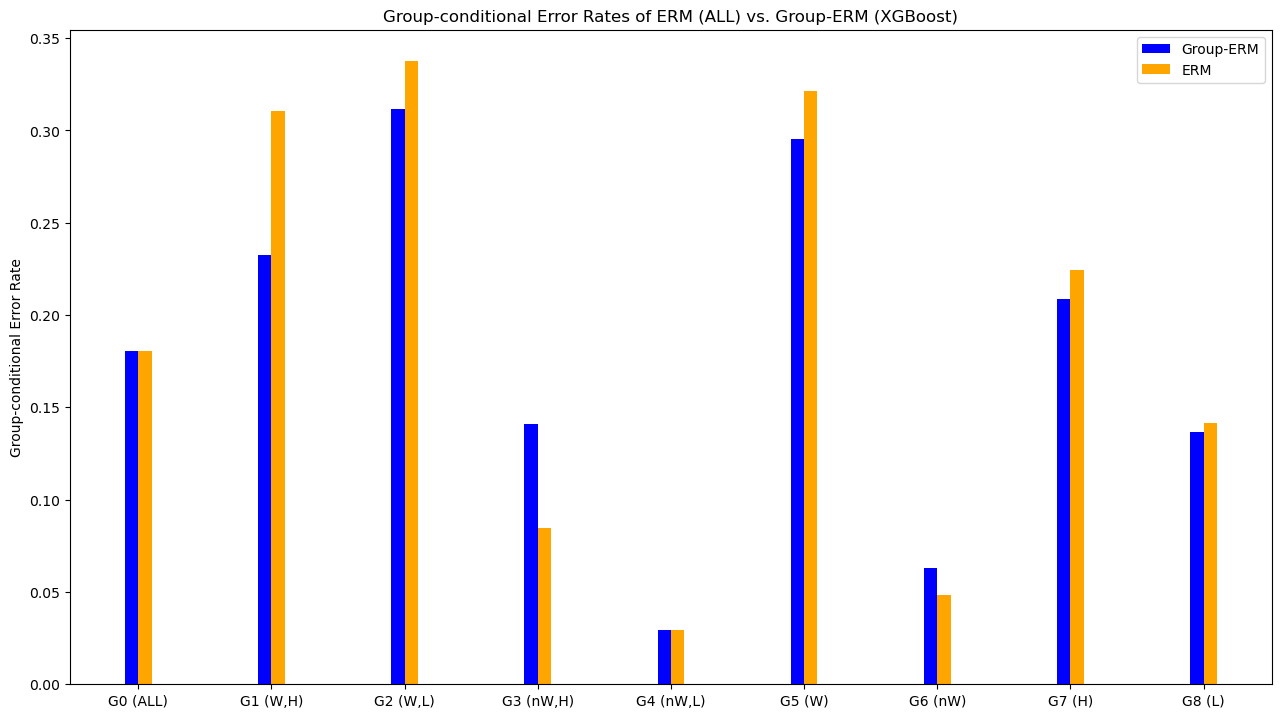

In [44]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, xgb_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, xgb_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, xgb_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, xgb_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (XGBoost)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

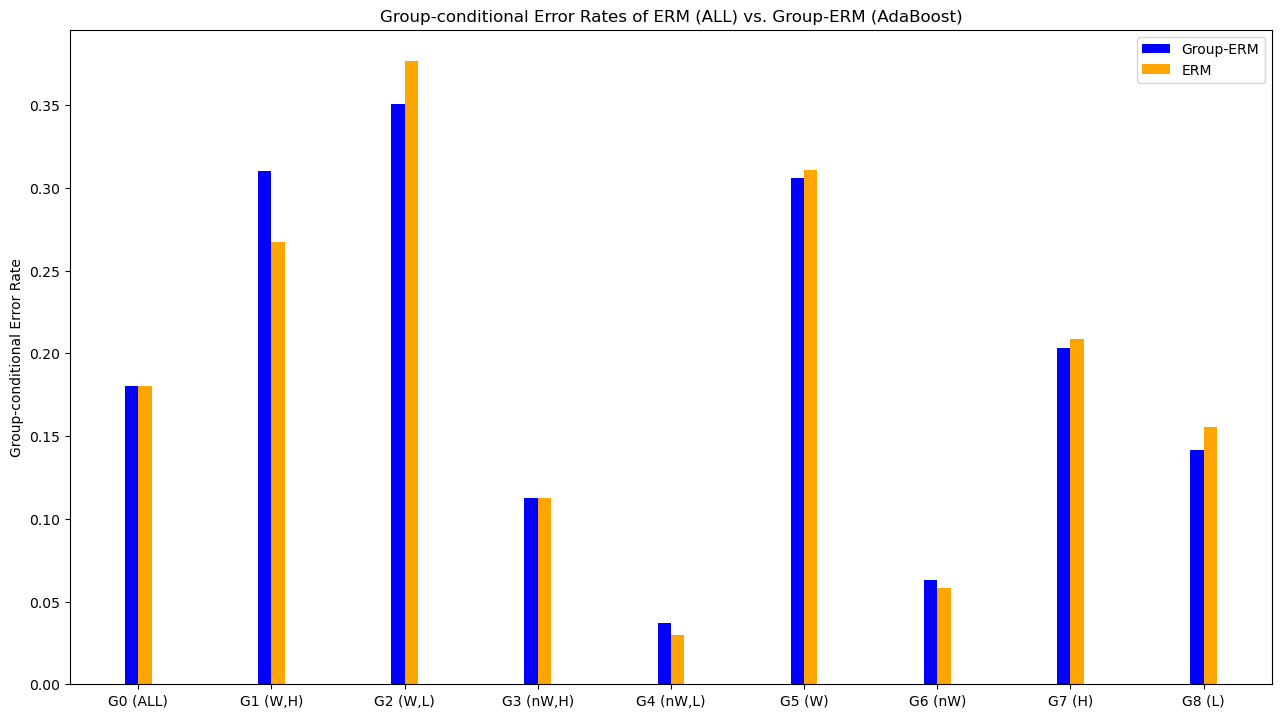

In [45]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, ada_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, ada_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, ada_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, ada_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (AdaBoost)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()